# 階段昇降の角運動解析物語  
データ分析の一部始終だ。それは試行錯誤の冒険であり，帰納的であり，だから「物語」なんだ。  
> 不必要なところもたくさんある。試行錯誤でやってるからだ。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lpf    #ローパスフィルタモジュール
import integral    #積分計算モジュール

## １．２つのデータフレームを時刻でマージする

◼️1-1. 大腿に装着したセンサのデータを`df1`，下腿に装着したセンサのデータを`df2`というデータフレームオブジェクトに読み込む：

In [2]:
df1 = pd.read_csv("sakamoto_daitai.csv", header=None, 
                 names=['item', 'time', 'a1_x', 'a1_y', 'a1_z', 'u1_x', 'u1_y','u1_z'])
df2 = pd.read_csv("sakamoto_katai.csv", header=None, 
                 names=['item', 'time', 'a2_x', 'a2_y', 'a2_z', 'u2_x', 'u2_y','u2_z'])

> 項目記号の先頭文字`a`と`u`はそれぞれ，加速度と角速度を示し，それらの後ろの番号`1`と`2`はそれぞれ，大腿を下腿を示す。また，記号の`_x`, `_y`および`_z`はそれぞれ，x成分，y成分およびz成分を示す。

◼️1-2. `df1`と`df2`の最初のレコードを表示する：

In [3]:
df1.head()

item      time  a1_x  a1_y  a1_z  u1_x  u1_y  u1_z
0  ags  53694657  9726   868 -1220   257    14    79
1  ags  53694658  9743   841 -1225   282     2    73
2  ags  53694659  9767   854 -1229   269    14    55
3  ags  53694660  9738   876 -1183   239     8    79
4  ags  53694661  9767   890 -1159   221     2    73

In [4]:
df2.head()

item      time  a2_x  a2_y  a2_z  u2_x  u2_y  u2_z
0  ags  53694747  9780  1220   420    94    58  -246
1  ags  53694748  9793  1191   413   106    89  -240
2  ags  53694749  9780  1194   364   112    64  -222
3  ags  53694750  9756  1201   430   112    46  -234
4  ags  53694751  9751  1164   369   118    52  -246

> データフレーム`df1`, `df2`の`time`を見てみよう。
>>この時刻は1日の最初を0時0分0.000秒を0として，1ms単位でその日の時刻を表した整数である。したがって，例えば`df1`の`time`の`53694657`は14時54分54.657秒，`df2`の`time`の`53694747`は14時54分54.747秒ということになる。

> あれれ？パソコンで２つのセンサを同期させたはずなのに，計測開始時刻が異なってるじゃないか！ そうなんだ，パソコンでセンサを同期しても，どうしても0.1秒のオーダーでデータを**取り損ねてしまう**んだ。ただし，時刻自体は**パソコンの時刻に合っている**。したがって，同期させた２つのセンサでデータ分析をする場合，計測時刻を合わせる必要がある。これをする手っ取り早い方法が，２つのデータフレームを，時刻をキーとして，マージ（統合）することだ。

****
### 【公式1】データフレームのマージ（教科書には載っていない）
```
pd.merge(df_1, df_2, ..., df_i, ..., df_n, on=['key1','key2', ...] )
```
**共通の項目**をもつ$n$個のデータフレーム，`df1`, `df2`, ..., `dfn`を`on=`の右辺で指定された**リスト内のキー項目(群)**でマージする。  

例えば，`on=`の右辺のリスト内の項目の１つが`'A'`であり，データフレーム`df_i`の項目`'A'`のデータの集合を$A_i$とする。その場合上記コマンドを実行すると，**$A_1 \cap A_2 \cap ... \cap A_i \cap ... \cap A_n$となるレコードのみを残し（そうならないレコードは削除され）**，共通の項目`A`としてn個のデータフレームを結合する。

※）共通の項目が１つの場合は，`on='key'`などとできる。
****

◼️1-3. `df1`と`df2`を，項目`'item'`と`'time'`でマージしてデータフレームオブジェクト`df`に格納し，`df`の最初と最後のレコードを表示してみる：

In [5]:
df = pd.merge(df1, df2, on=['item', 'time'])   #df1とdf2を項目'item'と'time'でマージ

In [6]:
df.head()    #dfの最初の部分の表示

item      time  a1_x  a1_y  a1_z  u1_x  u1_y  u1_z  a2_x  a2_y  a2_z  u2_x  \
0  ags  53694747  9662   854 -1227    87    21   273  9780  1220   420    94   
1  ags  53694748  9657   839 -1171    74    21   243  9793  1191   413   106   
2  ags  53694749  9711   900 -1195    62    21   219  9780  1194   364   112   
3  ags  53694750  9726   824 -1261    32    33   267  9756  1201   430   112   
4  ags  53694751  9718   773 -1229     1    39   292  9751  1164   369   118   

   u2_y  u2_z  
0    58  -246  
1    89  -240  
2    64  -222  
3    46  -234  
4    52  -246

In [7]:
df.tail()    #dfの最後に部分の表示

item      time  a1_x  a1_y  a1_z  u1_x  u1_y  u1_z  a2_x  a2_y  a2_z  \
98928  ags  53793675  9650  1168 -1430  -260   -10  -183  9653  1372   171   
98929  ags  53793676  9684  1161 -1537  -266     2  -165  9729  1338   176   
98930  ags  53793677  9706  1134 -1561  -284    14  -177  9761  1360   162   
98931  ags  53793678  9618  1129 -1437  -291     2  -146  9688  1345   110   
98932  ags  53793679  9633  1083 -1466  -297    33  -159  9636  1335   201   

       u2_x  u2_y  u2_z  
98928   -88    40   118  
98929   -94    46   131  
98930   -88    46   137  
98931  -100    28   137  
98932  -106    16   131

> 計測時刻（およびitem）が一致するところを残し，データフレームが１つに統合（マージ）された。

## ２．角速度の平滑化

◼️2-1. とりあえず，大腿と下腿の矢状面に垂直な角速度（z成分）をプロットしよう。２つのセンサを右脚の外側に，z軸が矢状面に対して垂直右方向につけたとき，**角速度の正負はどのような状態なのかを考えよ：**

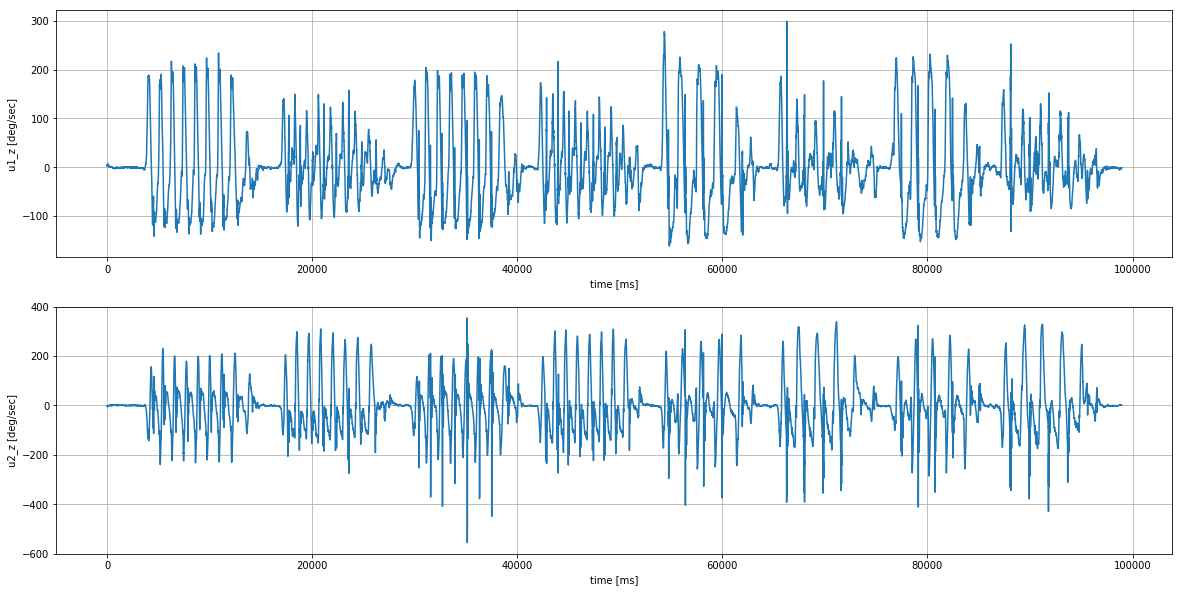

In [8]:
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)   #パレットを2行1列に分割し，1行目に以下のグラフをプロットする
plt.plot(df['u1_z']/100)   #100で割るのはu1_zの単位が 10^-2deg/s だから
plt.xlabel('time [ms]')    #x軸ラベル
plt.ylabel('u1_z [deg/sec]')    #y軸ラベル
plt.grid()   #プロット領域にグリッド線をつける

plt.subplot(2, 1, 2)   #パレットを2行1列に分割し，2行目に以下のグラフをプロットする
plt.plot(df['u2_z']/100)
plt.xlabel('time [ms]')
plt.ylabel('u2_z [deg/sec]')
plt.grid()

> 両グラフのそれぞれの８つの波の塊のうちの最初の４つは通常に階段降昇を行い，最後の４つは１段飛ばしで階段降昇を行っている。

◼️2-2. 50Hzのローパスフィルタでノイズとバイアス除去を行っておこう：
> 以前のローパスフィルタモジュールを汎用性をもたせるように改良した。このフォルダのモジュールを使ってくたまえ。なお，ローパスフィルタ関数のマニュアルは，`lpf.lpfilter?` を実行すれば確かめられる。

In [9]:
u1_z = lpf.lpfilter(df['u1_z']/100, 50)   #大腿角速度z成分
u2_z = lpf.lpfilter(df['u2_z']/100, 50)   #下腿角速度z成分

◼️2-3. `u1_z`, `u2_z`をプロットする：

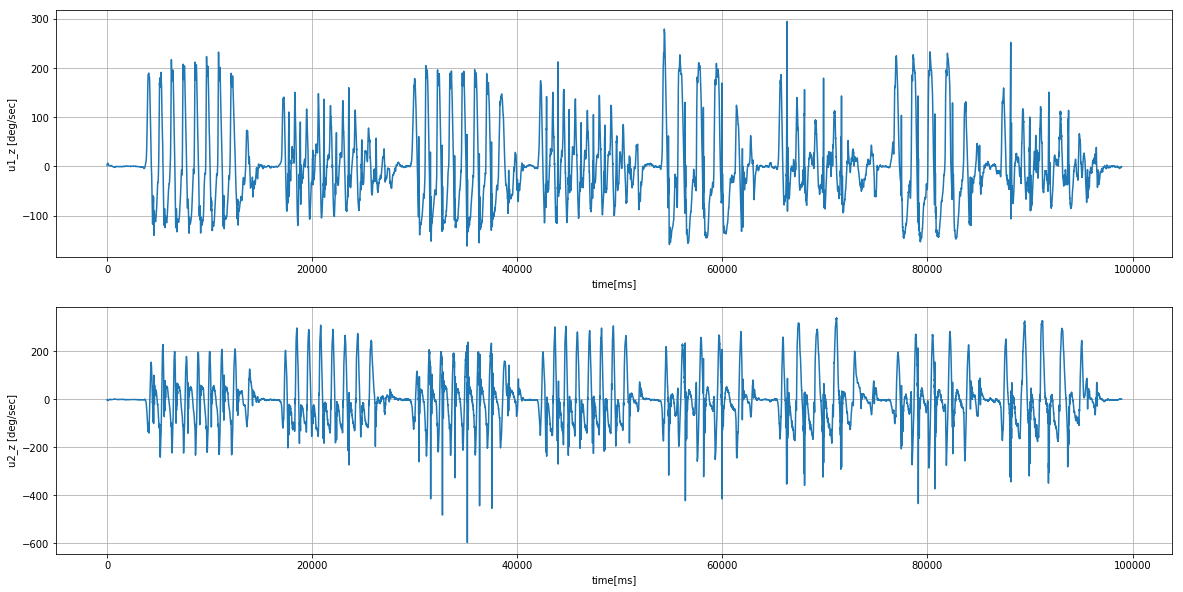

In [10]:
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)   #パレットを2行1列に分割し，1行目に以下のグラフをプロットする
plt.plot(u1_z)
plt.xlabel('time[ms]')
plt.ylabel(f'u1_z [deg/sec]')
plt.grid()

plt.subplot(2, 1, 2)   #パレットを2行1列に分割し，2行目に以下のグラフをプロットする
plt.plot(u2_z)
plt.xlabel('time[ms]')
plt.ylabel('u2_z [deg/sec]')
plt.grid()

◼️2-4. フィルタなしとあまり変化はないようだが，短い時間間隔（特に初期域）見ればよくわかる：

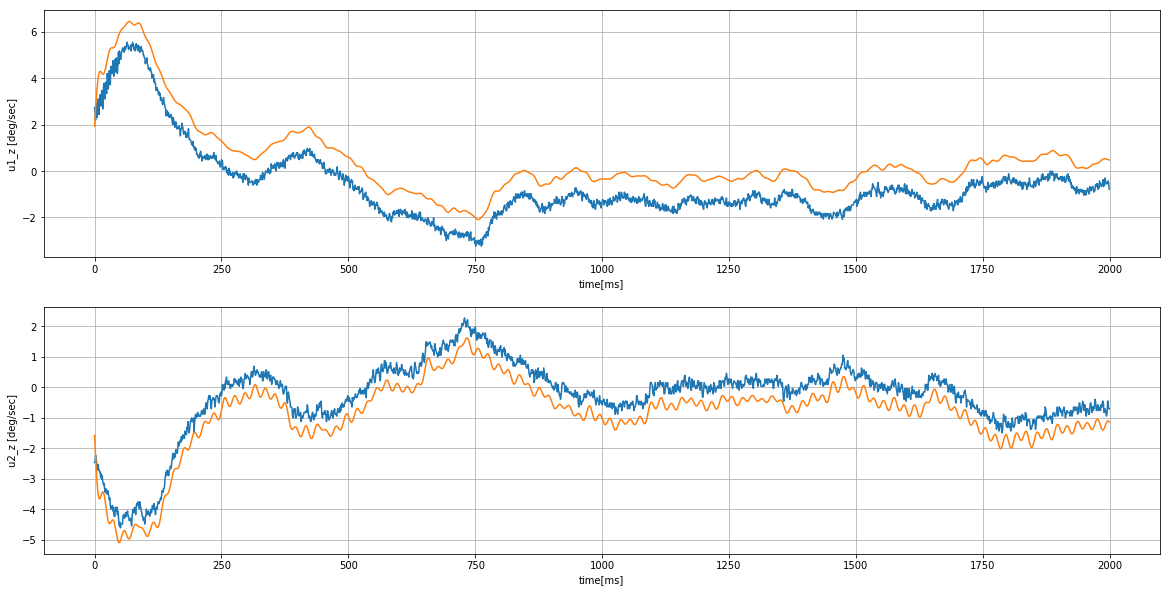

In [11]:
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)
plt.plot(np.array(df['u1_z']/100)[:2000])
plt.plot(u1_z[:2000])
plt.xlabel('time[ms]')
plt.ylabel(f'u1_z [deg/sec]')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(np.array(df['u2_z']/100)[:2000])
plt.plot(u2_z[:2000])
plt.xlabel('time[ms]')
plt.ylabel(f'u2_z [deg/sec]')
plt.grid()

◼️2-5. 上のグラフを見ると，（静止しているにも関わらず）1秒ちょっとまで変動がある。したがって，1.5秒(1500ms)までデータを取り除き，角速度データを再定義しておく：
> 教科書p.143-144

In [12]:
u1_z = u1_z[1500:]   #大腿角速度z成分
u2_z = u2_z[1500:]   #下腿角速度z成分

◼️2-6. 大腿と下腿の矢状面に垂直なそれぞれの角速度`u1_z`と`u2_z`をプロットしてみよう：

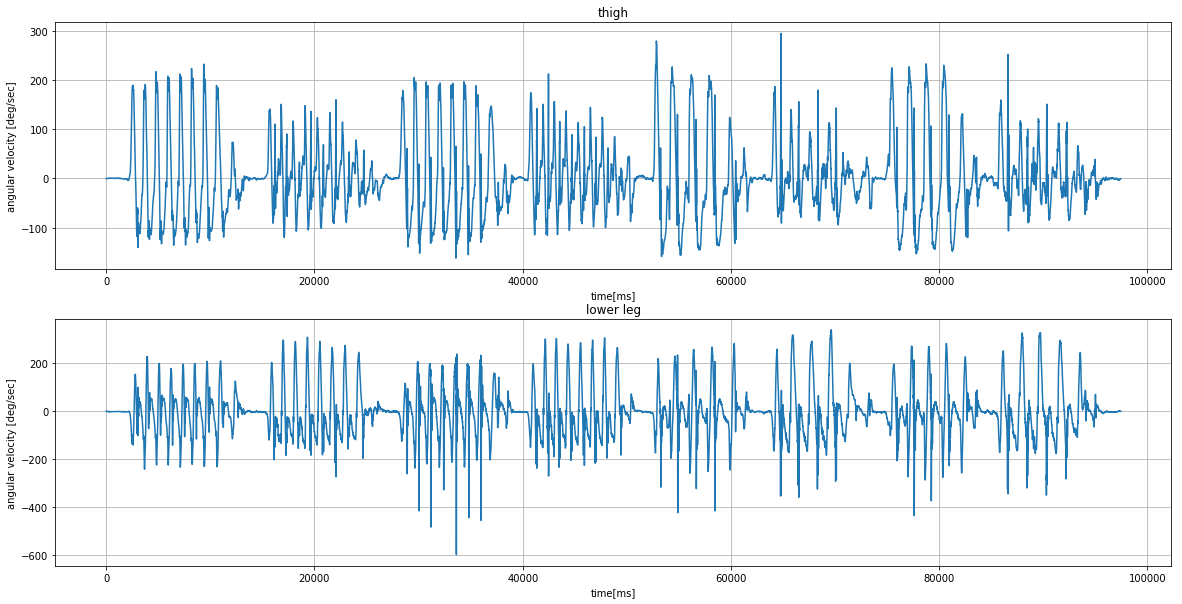

In [13]:
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)   #パレットを2行1列に分割し，1行目に以下のグラフをプロットする
plt.plot(u1_z)
plt.xlabel('time[ms]')
plt.ylabel(f'angular velocity [deg/sec]')
plt.title('thigh')
plt.grid()

plt.subplot(2, 1, 2)   #パレットを2行1列に分割し，2行目に以下のグラフをプロットする
plt.plot(u2_z)
plt.xlabel('time[ms]')
plt.ylabel('angular velocity [deg/sec]')
plt.title('lower leg')
plt.grid()

◼️2-7. ちなみに最初の階段降り昇り状態をプロットしてみよう：
> 第２図以降の`plt.plot`関数の第１引数にある，`np.arange(開始整数, 終了整数)`は`開始整数`〜`終了整数-1`の増分`1`の1D-numpy配列を与える。たとえば:
>> 教科書p.105

```
    In[999] : np.arange(14000, 28000)
    Out[999]: array([14000, 14001, 14002, ..., 27997, 27998, 27999])
```

> `np.arange(開始整数, 終了整数)`を`plt.plot`関数の第１引数に与えることによって，プロットする関数の独立変数を陽に指定できる。つまり今の場合，（開始時刻を0[ms]とした）実験時刻を横軸に指定できる。
>> 教科書p.259

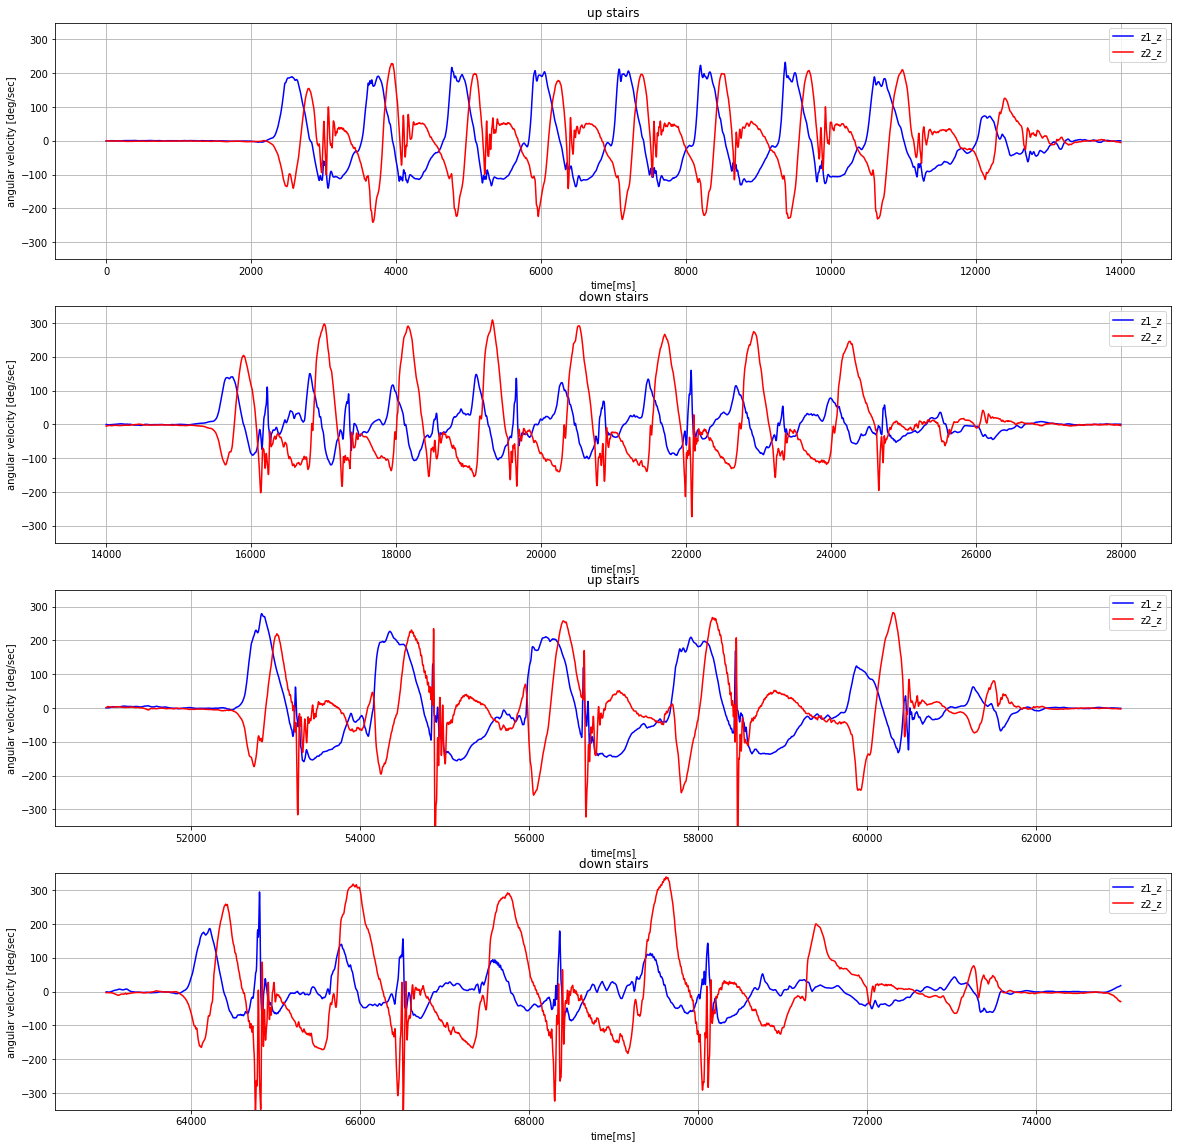

In [14]:
plt.figure(figsize=(20,20))

plt.subplot(4, 1, 1)   #パレットを4行1列に分割し，1行目に以下のグラフをプロットする
plt.plot(u1_z[:14000], c='blue')
plt.plot(u2_z[:14000], c='red')
plt.title('up stairs')
plt.xlabel('time[ms]')
plt.ylabel('angular velocity [deg/sec]')
plt.ylim([-350, 350])
plt.legend(['z1_z', 'z2_z'])
plt.grid()   #プロット領域にグリッド線をつける

plt.subplot(4, 1, 2)   #パレットを4行1列に分割し，2行目に以下のグラフをプロットする
plt.plot(np.arange(14000,28000), u1_z[14000:28000], c='blue')
plt.plot(np.arange(14000,28000), u2_z[14000:28000], c='red')
plt.title('down stairs')
plt.xlabel('time[ms]')
plt.ylabel('angular velocity [deg/sec]')
plt.ylim([-350, 350])
plt.legend(['z1_z', 'z2_z'])
plt.grid()

plt.subplot(4, 1, 3)   #パレットを4行1列に分割し，3行目に以下のグラフをプロットする
plt.plot(np.arange(51000, 63000), u1_z[51000:63000], c='blue')
plt.plot(np.arange(51000, 63000), u2_z[51000:63000], c='red')
plt.title('up stairs')
plt.xlabel('time[ms]')
plt.ylabel('angular velocity [deg/sec]')
plt.ylim([-350, 350])
plt.legend(['z1_z', 'z2_z'])
plt.grid()

plt.subplot(4, 1, 4)   #パレットを4行1列に分割し，4行目に以下のグラフをプロットする
plt.plot(np.arange(63000,75000), u1_z[63000:75000], c='blue')
plt.plot(np.arange(63000,75000), u2_z[63000:75000], c='red')
plt.title('down stairs')
plt.xlabel('time[ms]')
plt.ylabel('angular velocity [deg/sec]')
plt.ylim([-350, 350])
plt.legend(['z1_z', 'z2_z'])
plt.grid()

## ３．大腿と下腿の傾き角

◼️3-1. 角速度を時間積分することによって，大腿と下腿の傾き角を求めよう。ここで，大腿または下腿が鉛直から後ろに傾いたときに正の角，前に傾いたときに負の角を与えることに注意しよう。
> ただし，**初期角を0degと仮定**したときという条件付きである。実際は，重力によって鉛直を決めてそれに対して初期角が何degになるかを求めなければならないが，座標変換等の複雑な数学が必要になるので，ここではそのことを考慮するのはやめておこう。  

数値積分は前の課題でプログラムしたので，アルゴリズムは解っていると思う。したがって，ここでの解析では，またこれをいちいちプログラムするのは面倒なので，`integral.py`というモジュールの中に関数を書いておいた。それを利用することにしよう。

***
### 【公式2】数値積分関数(台形則) 
```
integral.trapez(サンプルデータ配列, 初期値, 最初のindex, 最後のindex)
```
1000Hzの`サンプルデータ配列`を被積分関数配列として，配列の(任意の)`最初のindex`から(任意の)`最後のindex`まで数値積分した積分関数配列を返す。ただし，`初期値`は`最初のindex`のときに積分に与えられる値である。  
1. 台形則にもとづいた数値積分である。
2. 1000Hz以外のサンプルデータでは，`tau=1/周波数` オプションを用いればよい。詳しくは，マニュアル `integral.trapez?` を実行せよ。  
***

***
### 【公式2補】数値積分関数(シンプソン則) 
```
integral.simps(サンプルデータ配列, 初期値, 最初のindex, 最後のindex)
```
1000Hzの`サンプルデータ配列`を被積分関数配列として，配列の(任意の)`最初のindex`から(任意の)`最後のindex`まで数値積分した積分関数配列を返す。ただし，`初期値`は`最初のindex`のときに積分に与えられる値である。  
1. シンプソン則にもとづいた数値積分である。
2. 1000Hz以外のサンプルデータでは，`tau=1/周波数` オプションを用いればよい。詳しくは，マニュアル `integral.simps?` を実行せよ。
3. 公式2の台形則より精度が高い（積分誤差が少ない）が，計算に時間を要する。
***

◼️3-2. 大腿の傾き角を`alpha`, 下腿の傾き角を`beta`とすると，`alpha`, `beta`は公式2を用いて次のように算出される：
> `integral.trapez?`  
> でマニュアル参照。

In [15]:
alpha = integral.trapez(u1_z, 0, 0, len(u1_z)-1)
beta = integral.trapez(u2_z, 0, 0, len(u2_z)-1)

◼️3-3. `alpha`, `beta`をプロットすると：

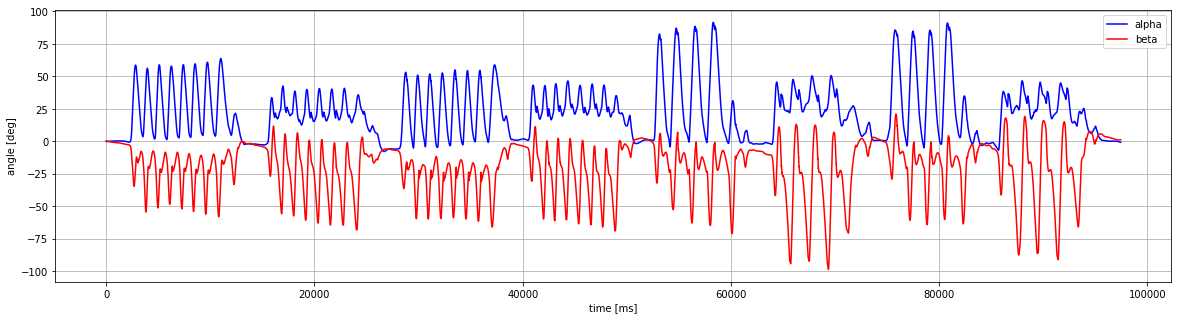

In [16]:
plt.figure(figsize=(20,5))
plt.plot(alpha, c='blue')
plt.plot(beta, c='red')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg]')
plt.legend(['alpha', 'beta'])
plt.grid()

> なぜこのようなグラフになるか，考えてみよ。特に，下腿の傾き角が負に出ていることを考えよ。

◼️3-4. ちなみに最初の階段昇りと降り状態をプロットしてみよう：

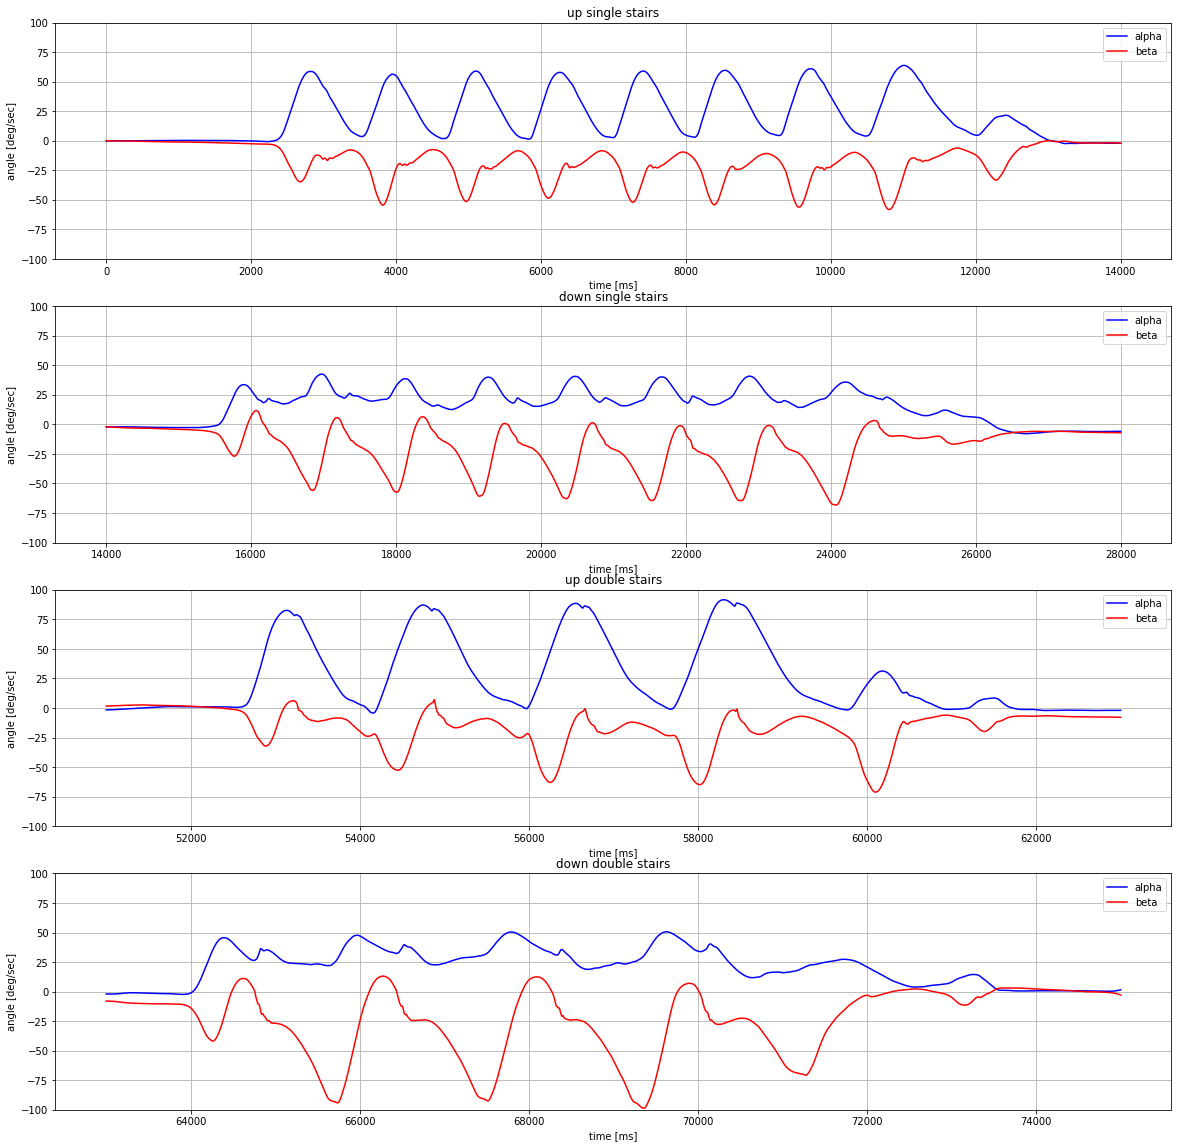

In [17]:
plt.figure(figsize=(20,20))

plt.subplot(4, 1, 1)
plt.plot(alpha[:14000], c='blue')
plt.plot(beta[:14000], c='red')
plt.title('up single stairs')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg/sec]')
plt.ylim([-100, 100])
plt.legend(['alpha', 'beta'])
plt.grid()

plt.subplot(4, 1, 2)
plt.plot(np.arange(14000, 28000), alpha[14000:28000], c='blue')
plt.plot(np.arange(14000, 28000), beta[14000:28000], c='red')
plt.title('down single stairs')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg/sec]')
plt.ylim([-100, 100])
plt.legend(['alpha', 'beta'])
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(np.arange(51000, 63000), alpha[51000:63000], c='blue')
plt.plot(np.arange(51000, 63000), beta[51000:63000], c='red')
plt.title('up double stairs')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg/sec]')
plt.ylim([-100, 100])
plt.legend(['alpha', 'beta'])
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(np.arange(63000, 75000), alpha[63000:75000], c='blue')
plt.plot(np.arange(63000, 75000), beta[63000:75000], c='red')
plt.title('down double stairs')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg/sec]')
plt.ylim([-100, 100])
plt.legend(['alpha', 'beta'])
plt.grid()

◼️3-5. 位相空間では以下のような軌跡を描く：

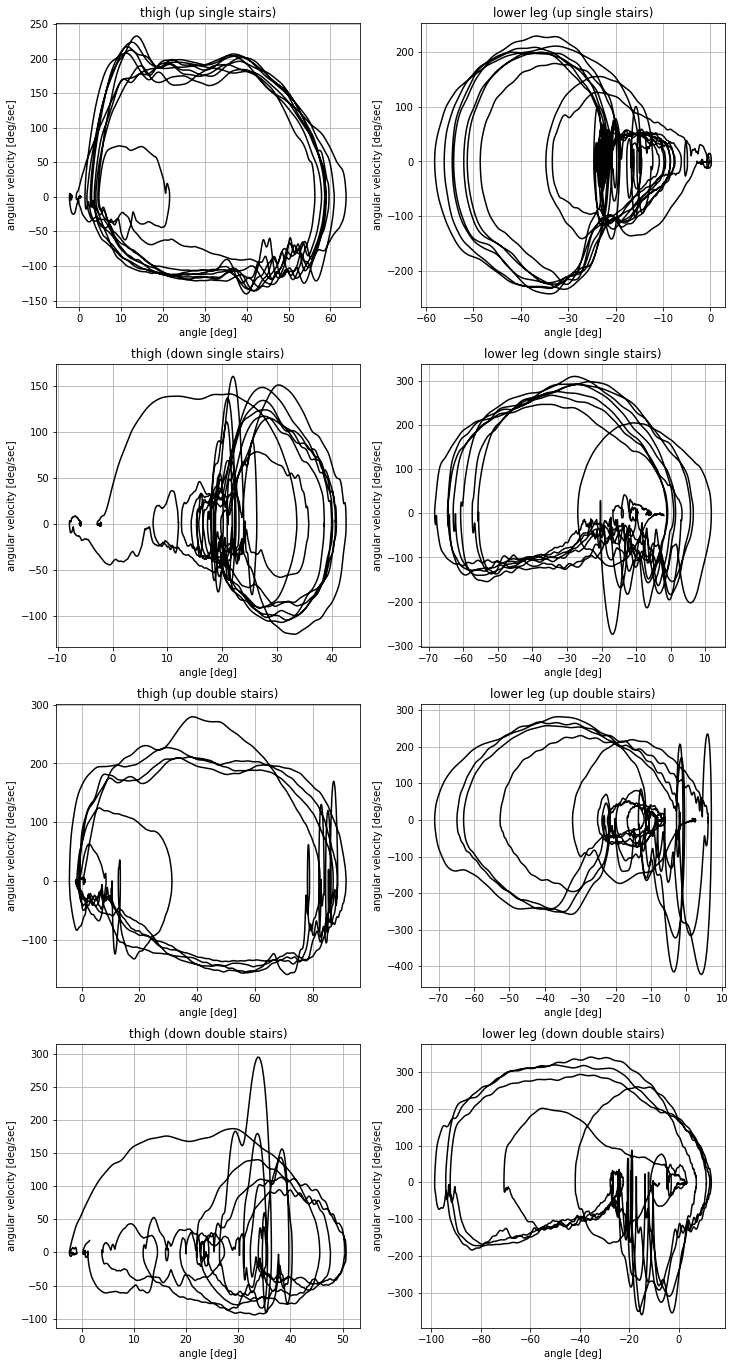

In [18]:
plt.figure(figsize=(12,24))

plt.subplot(4, 2, 1)    #パレットを4行2列に分割し，一番左上に以下のプロットを描く
plt.plot(alpha[0:14000], u1_z[0:14000], c='black')
plt.title('thigh (up single stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 2)
plt.plot(beta[0:14000], u2_z[0:14000],  c='black')
plt.title('lower leg (up single stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 3)
plt.plot(alpha[14000:28000], u1_z[14000:28000], c='black')
plt.title('thigh (down single stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 4)
plt.title('lower leg (down single stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/sec]')
plt.plot(beta[14000:28000], u2_z[14000:28000],  c='black')
plt.grid()

plt.subplot(4, 2, 5)
plt.plot(alpha[51000:63000], u1_z[51000:63000], c='black')
plt.title('thigh (up double stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 6)
plt.plot(beta[51000:63000], u2_z[51000:63000],  c='black')
plt.title('lower leg (up double stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 7)
plt.plot(alpha[63000:75000], u1_z[63000:75000], c='black')
plt.title('thigh (down double stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 8)    #パレットを4行2列に分割し，一番右下に以下のプロットを描く
plt.title('lower leg (down double stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/sec]')
plt.plot(beta[63000:75000], u2_z[63000:75000],  c='black')
plt.grid()

> 位相空間で１組の波形群をすべて表示すると，こんな落書きになってしまい，運動状態がまるでカオスだ。

◼️3-6. １組の波形群からティピカルな１周期分をとりだして，位相空間内の角運動の軌跡を描いてみよう：

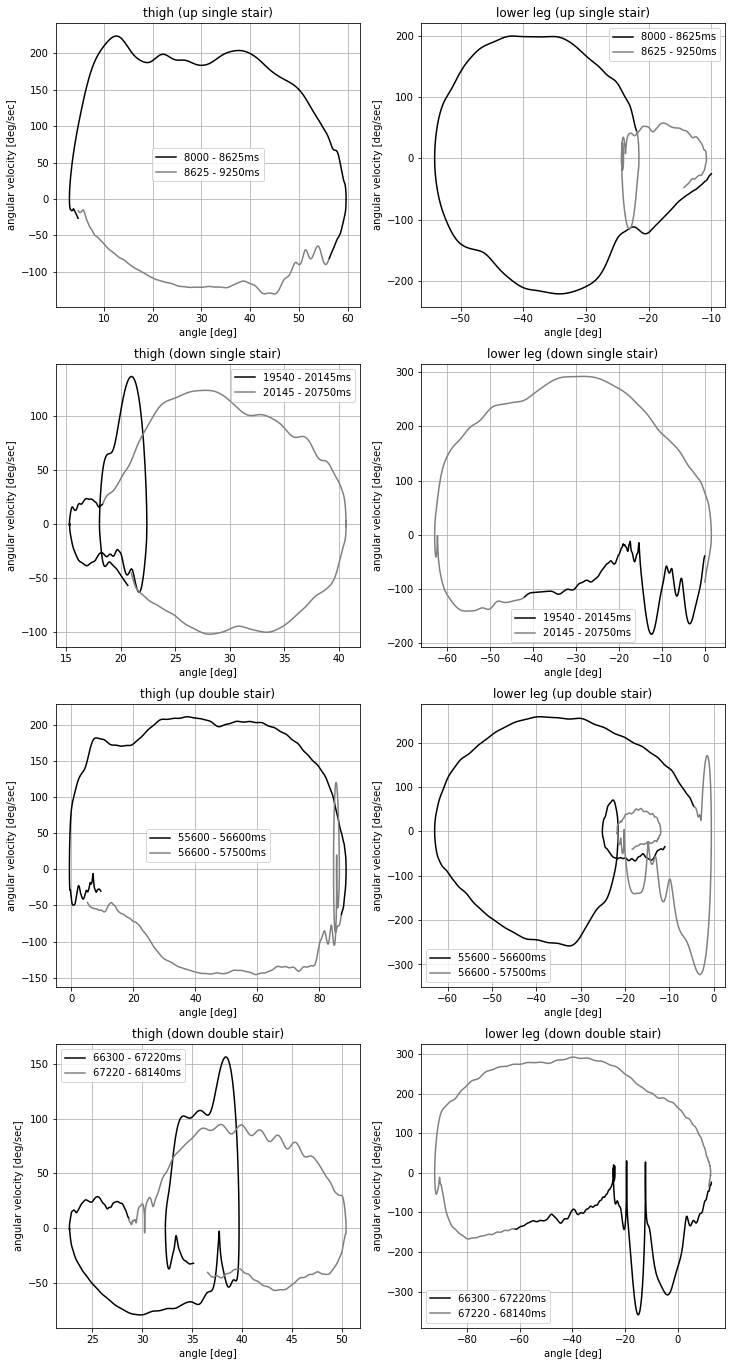

In [19]:
plt.figure(figsize=(12,24))

plt.subplot(4, 2, 1)
plt.plot(alpha[8000:8625], u1_z[8000:8625], c='black')
plt.plot(alpha[8625:9250], u1_z[8625:9250], c='gray')
plt.legend(['8000 - 8625ms', '8625 - 9250ms'])
plt.title('thigh (up single stair)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 2)
plt.plot(beta[8000:8625], u2_z[8000:8625],  c='black')
plt.plot(beta[8625:9250], u2_z[8625:9250],  c='gray')
plt.legend(['8000 - 8625ms', '8625 - 9250ms'])
plt.title('lower leg (up single stair)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 3)
plt.plot(alpha[19540:20145], u1_z[19540:20145], c='black')
plt.plot(alpha[20145:20750], u1_z[20145:20750], c='gray')
plt.legend(['19540 - 20145ms', '20145 - 20750ms'])
plt.title('thigh (down single stair)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 4)
plt.plot(beta[19540:20145], u2_z[19540:20145], c='black')
plt.plot(beta[20145:20750], u2_z[20145:20750], c='gray')
plt.legend(['19540 - 20145ms', '20145 - 20750ms'])
plt.title('lower leg (down single stair)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 5)
plt.plot(alpha[55600:56600], u1_z[55600:56600], c='black')
plt.plot(alpha[56600:57500], u1_z[56600:57500], c='gray')
plt.legend(['55600 - 56600ms', '56600 - 57500ms'])
plt.title('thigh (up double stair)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 6)
plt.plot(beta[55600:56600], u2_z[55600:56600],  c='black')
plt.plot(beta[56600:57500], u2_z[56600:57500],  c='gray')
plt.legend(['55600 - 56600ms', '56600 - 57500ms'])
plt.title('lower leg (up double stair)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 7)
plt.plot(alpha[66300:67220], u1_z[66300:67220], c='black')
plt.plot(alpha[67220:68140], u1_z[67220:68140], c='gray')
plt.legend(['66300 - 67220ms', '67220 - 68140ms'])
plt.title('thigh (down double stair)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 8)
plt.plot(beta[66300:67220], u2_z[66300:67220], c='black')
plt.plot(beta[67220:68140], u2_z[67220:68140], c='gray')
plt.legend(['66300 - 67220ms', '67220 - 68140ms'])
plt.title('lower leg (down double stair)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/sec]')
plt.grid()

> ループが２つあるのは，（１周期に）二峰性の振動，つまり，１回の昇または降動作で大腿または下腿が行ったり来たり（傾いたり起きたり）しているということだ。

## ４．膝屈曲角解析

◼️4-1. 大腿および下腿の単体の角運動はあまり意味がないというか，おもしろくない。君たちの興味は，膝屈曲角の角運動だと思う。いま，膝屈曲角を`theta`, 膝屈曲角速度を`omega`とすると，それらは次のように算出される：
> 大腿を固定したとすると，膝屈曲角速度を計測するためには，センサを右下腿内側（左下腿外側）に装着しなければならないことに注意せよ。

In [20]:
theta = alpha - beta
omega = u1_z - u2_z

◼️4-2. 膝屈曲角と角速度をプロットしてみる：

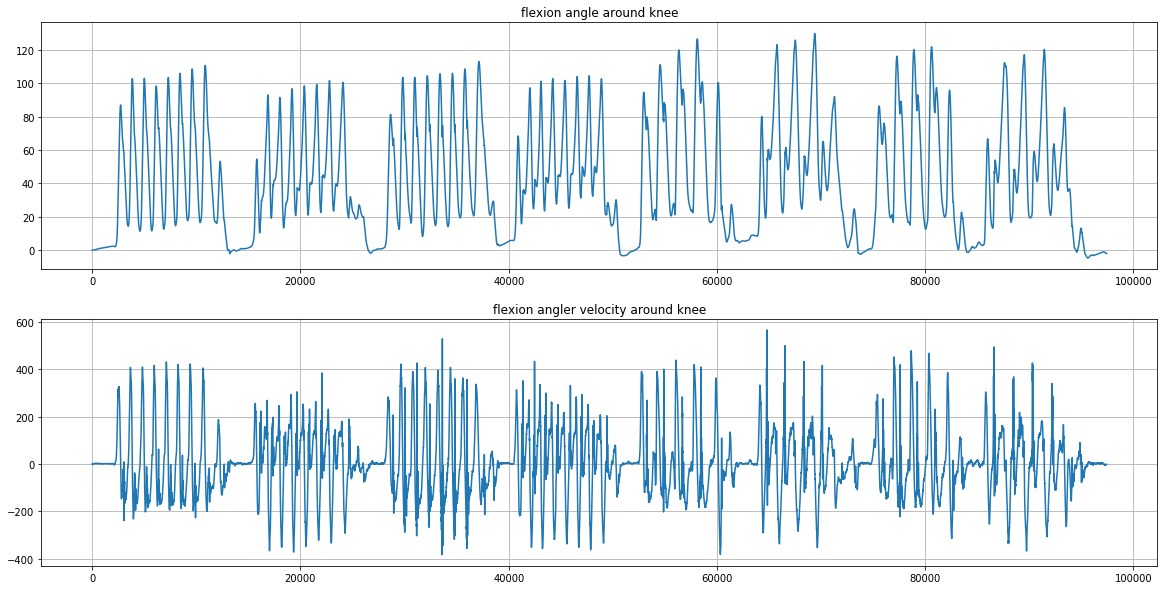

In [21]:
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)   #パレットを2行1列に分割し，1行目に以下のグラフをプロットする
plt.plot(theta)
plt.title('flexion angle around knee')
plt.grid()

plt.subplot(2, 1, 2)   #パレットを2行1列に分割し，2行目に以下のグラフをプロットする
plt.title('flexion angler velocity around knee')
plt.plot(omega)
plt.grid()

◼️4-3. 見やすくするために，最初の階段降り昇りの屈曲角および屈曲角速度をプロットしてみよう：

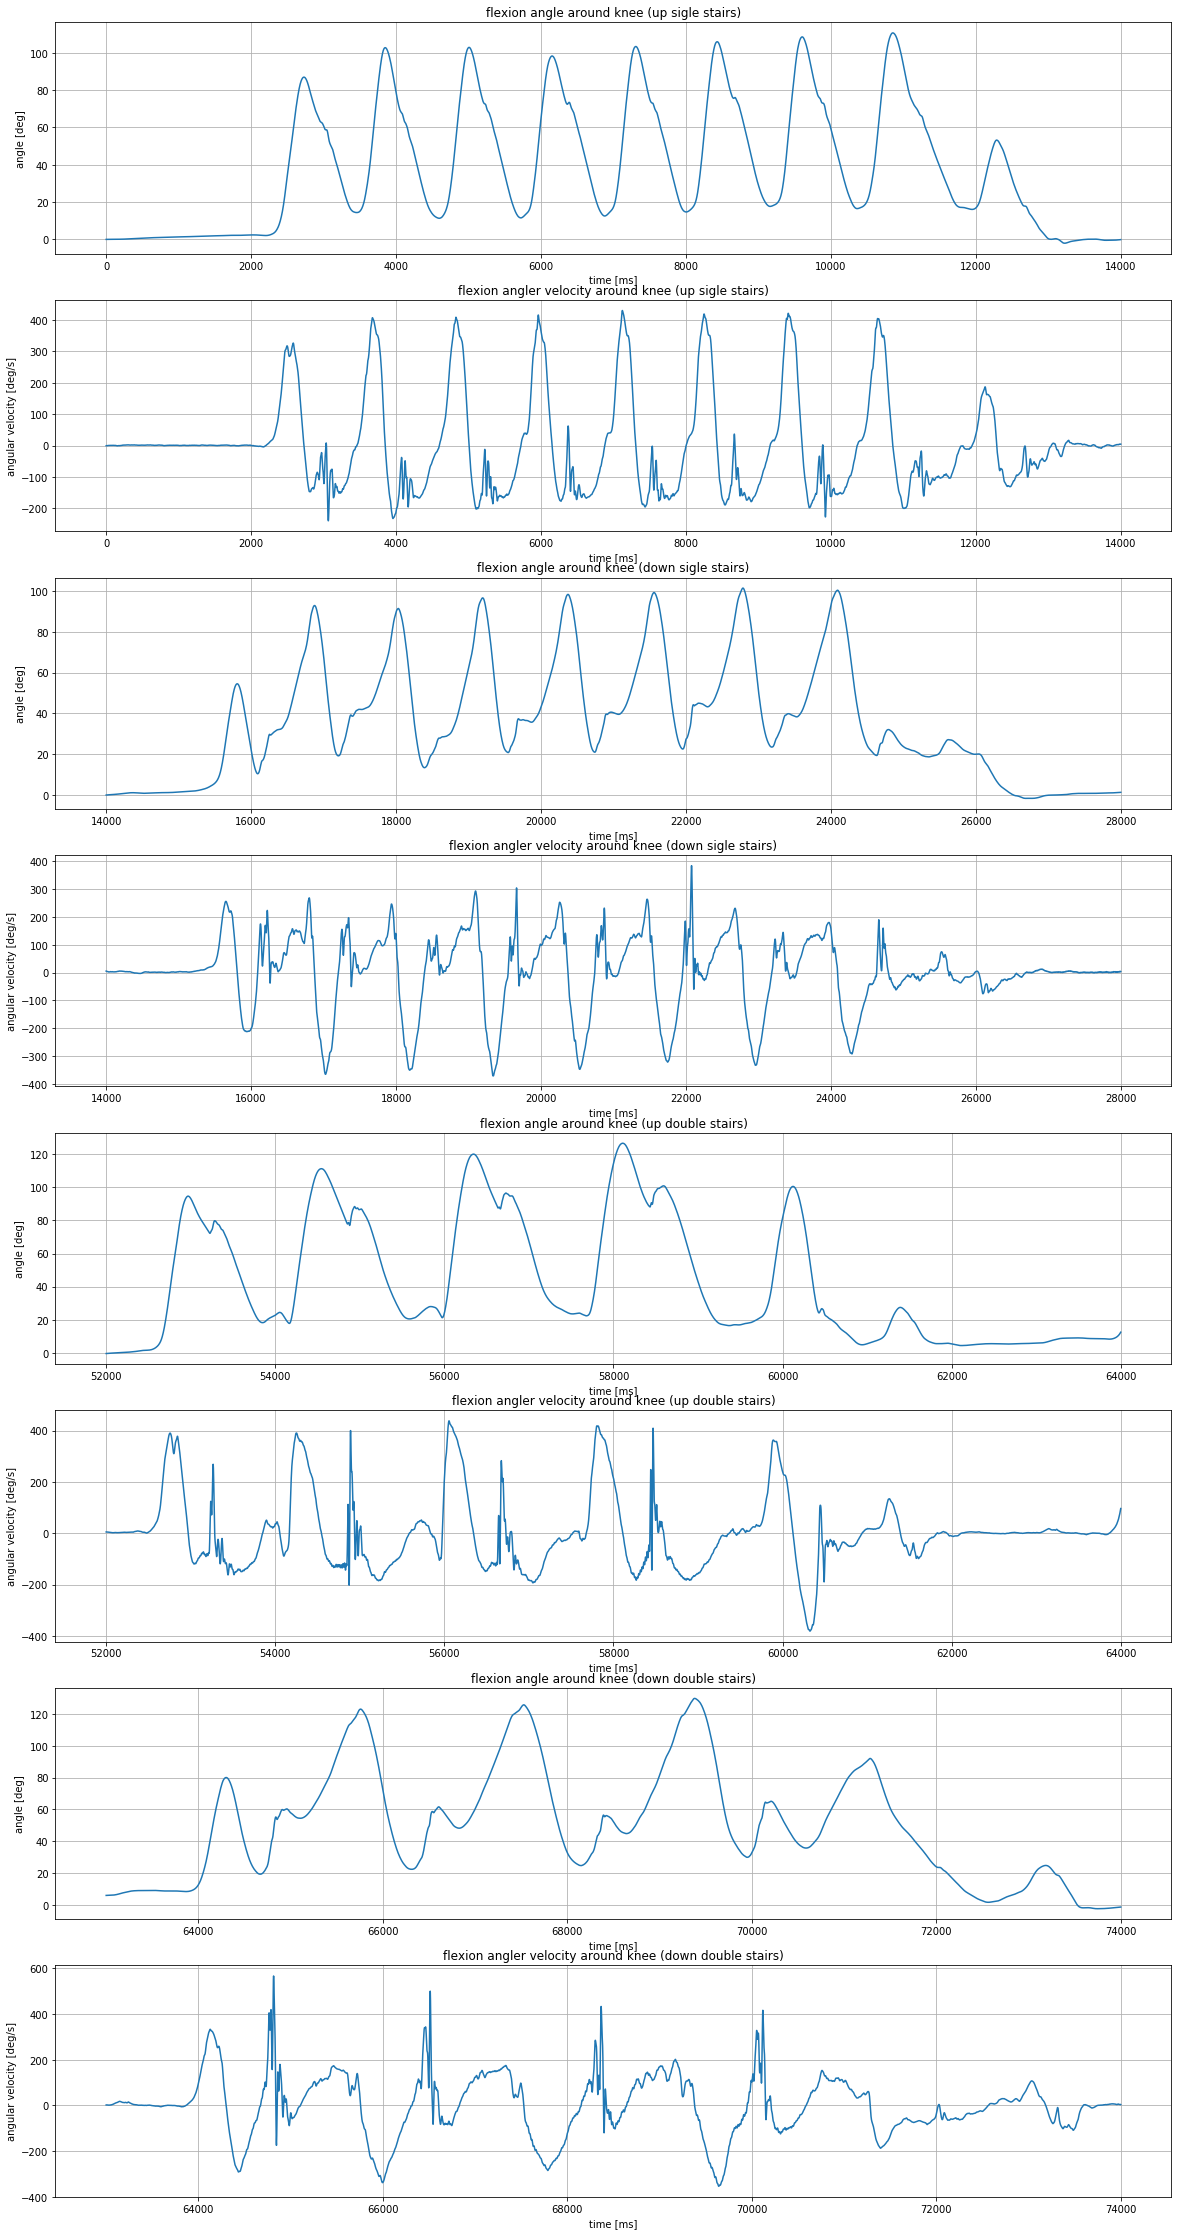

In [22]:
plt.figure(figsize=(20,40))

plt.subplot(8, 1, 1)   #パレットを8行1列に分割し，1行目に以下のグラフをプロットする
plt.plot(theta[:14000])
plt.title('flexion angle around knee (up sigle stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg]')
plt.grid()

plt.subplot(8, 1, 2)   #パレットを8行1列に分割し，2行目に以下のグラフをプロットする
plt.plot(omega[:14000])
plt.title('flexion angler velocity around knee (up sigle stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angular velocity [deg/s]')
plt.grid()

plt.subplot(8, 1, 3)   #パレットを8行1列に分割し，3行目に以下のグラフをプロットする
plt.plot(np.arange(14000, 28000), theta[14000:28000])
plt.title('flexion angle around knee (down sigle stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg]')
plt.grid()

plt.subplot(8, 1, 4)   #パレットを8行1列に分割し，4行目に以下のグラフをプロットする
plt.plot(np.arange(14000, 28000), omega[14000:28000])
plt.title('flexion angler velocity around knee (down sigle stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angular velocity [deg/s]')
plt.grid()

plt.subplot(8, 1, 5)   #パレットを8行1列に分割し，5行目に以下のグラフをプロットする
plt.plot(np.arange(52000, 64000), theta[52000:64000])
plt.title('flexion angle around knee (up double stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg]')
plt.grid()

plt.subplot(8, 1, 6)   #パレットを8行1列に分割し，6行目に以下のグラフをプロットする
plt.plot(np.arange(52000, 64000), omega[52000:64000])
plt.title('flexion angler velocity around knee (up double stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angular velocity [deg/s]')
plt.grid()

plt.subplot(8, 1, 7)   #パレットを8行1列に分割し，7行目に以下のグラフをプロットする
plt.plot(np.arange(63000, 74000), theta[63000:74000])
plt.title('flexion angle around knee (down double stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg]')
plt.grid()

plt.subplot(8, 1, 8)   #パレットを8行1列に分割し，8行目に以下のグラフをプロットする
plt.plot(np.arange(63000, 74000), omega[63000:74000])
plt.title('flexion angler velocity around knee (down double stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angular velocity [deg/s]')
plt.grid()

◼️4-4. 位相空間では，膝屈曲角運動は次のような軌跡を描く：

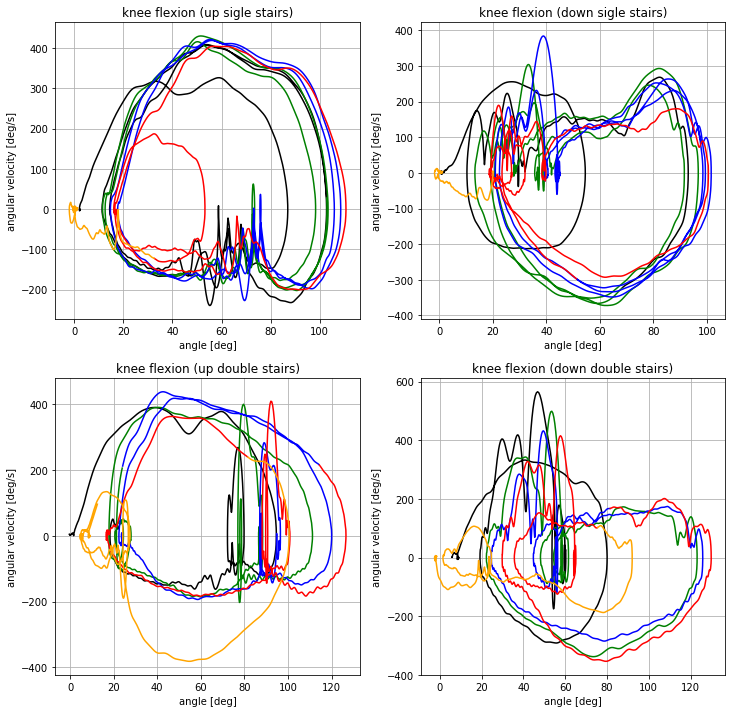

In [23]:
plt.figure(figsize=(12,12))

plt.subplot(2, 2, 1)    #パレットを2行2列に分割し，一番左上に以下のグラフを描く
plt.plot(theta[2000:5000], omega[2000:5000], c='black')
plt.plot(theta[5000:7500], omega[5000:7500], c='green')
plt.plot(theta[7500:10000], omega[7500:10000], c='blue')
plt.plot(theta[10000:12500], omega[10000:12500], c='red')
plt.plot(theta[12500:15000], omega[12500:15000], c='orange')
plt.title('knee flexion (up sigle stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/s]')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(theta[14000:17000], omega[14000:17000], c='black')
plt.plot(theta[17000:20000], omega[17000:20000], c='green')
plt.plot(theta[20000:23000], omega[20000:23000], c='blue')
plt.plot(theta[23000:26000], omega[23000:26000], c='red')
plt.plot(theta[26000:28000], omega[26000:28000], c='orange')
plt.title('knee flexion (down sigle stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/s]')
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(theta[52000:54000], omega[52000:54000], c='black')
plt.plot(theta[54000:56000], omega[54000:56000], c='green')
plt.plot(theta[56000:58000], omega[56000:58000], c='blue')
plt.plot(theta[58000:60000], omega[58000:60000], c='red')
plt.plot(theta[60000:64000], omega[60000:64000], c='orange')
plt.title('knee flexion (up double stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/s]')
plt.grid()

plt.subplot(2, 2, 4)    #パレットを2行2列に分割し，一番右下に以下のグラフを描く
plt.plot(theta[63000:65000], omega[63000:65000], c='black')
plt.plot(theta[65000:67000], omega[65000:67000], c='green')
plt.plot(theta[67000:69000], omega[67000:69000], c='blue')
plt.plot(theta[69000:71000], omega[69000:71000], c='red')
plt.plot(theta[71000:74000], omega[71000:74000], c='orange')
plt.title('knee flexion (down double stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/s]')
plt.grid()


◼️4-5.　１組の波形群（4-3）からティピカルな１周期分をとりだして，位相空間内の膝屈曲角運動の軌跡を描いてみよう。時刻はある波形群の中の１周期分についての屈曲角の**初めの極小値から次の極小値まで**とし，その時間間隔の半分で黒とグレーのカーブに分けることにしよう。その手続きを順を追って逐次行っていこう：

▫︎4-5-1. 4-3の最初のグラフで，`8000`ms付近で１つの極小値，`9000`ms付近で次の極小値がある。これらの大体の時刻を`t0`, `t1`とする。`t0`付近の少し前の時刻を`ti = t0 - epsilon`, `t1`の少し後の時刻を`tf = t1 - epsilon`，`epsilon = 500`としよう。また，`ti`と`tf`の中間時刻（割り切れない場合は小数部をカット）を`tm`としよう：

In [24]:
t0 = 8000
t1 = 9000
epsilon = 500
ti = t0 - epsilon
tf = t1 + epsilon
tm = ti + (tf - ti) // 2
print(f'ti={ti}, tf={tf}, tm={tm}')

ti=7500, tf=9500, tm=8500


▫︎4-5-2. `ti=7500`〜`tm=8500`には`theta`はたった１つの極小値しかもたない。同様に，`tm=8500`〜`tf=9500`にも`theta`はたった１つの極小値しかもたない。前者の極小値の時刻(インデックス)を`xi`，後者の極小値の時刻(インデックス)をxfとする。さらに，`xi`と`xf`の中間時刻（割り切れない場合は小数部をカット）を`xm`としよう：  
> `np.where`関数は例えば，<a href="https://deepage.net/features/numpy-where.html">「条件式を指定するNumPyのwhereの使い方」<a> を見よ。

In [25]:
xi = np.where(theta==np.min(theta[ti:tm]))[0][0]   #np.minは教科書p.129を参照
xf = np.where(theta==np.min(theta[tm:tf]))[0][0]
xm = xi + (xf - xi) // 2
print(f'xi={xi}, xf={xf}, xm={xm}')

xi=8002, xf=9160, xm=8581


> 屈曲角`theta`のある１周期は，`8002`msから始まり`9160`msで終わっており，その中間時刻は`9160`msである。

▫︎4-5-3. 位相空間で時刻xi=8002〜xf=9160の運動を黒曲線で，xf=9160〜xm=8581の運動をグレー曲線で描いてみよう：

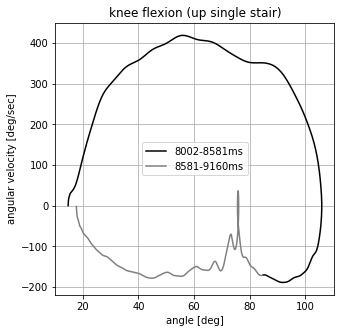

In [26]:
plt.figure(figsize=(5,5))
plt.plot(theta[xi:xm], omega[xi:xm], c='black')
plt.plot(theta[xm:xf], omega[xm:xf], c='gray')
plt.legend(['8002-8581ms', '8581-9160ms'])
plt.title('knee flexion (up single stair)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/sec]')
plt.grid()

> すばらしい！　しかし，この作業をすべての屈曲角運動パターンについて行うんだって？　めんどくせー！　こんな煩雑で機械的作業はスクリプト（プログラム）を書いて関数化する。

◼️4-6. 4-5にしたがって，１周期分の位相空間における運動の軌跡をプロットする関数を`rv_plot`という名前でコーディングしてみよう：

In [27]:
def rv_plot(r, v, t0, t1, epsilon=500, title='', redrange=None):
    #rとvはそれぞれ対応するarray, t0とt1は第１と第２の極小値近傍時刻, itimeオプションは後のため
    ti = t0 - epsilon
    tf = t1 + epsilon
    tm = ti + (tf - ti) // 2    #tm は ti ~ tf の中間インデックス
    xi = np.where(r==np.min(r[ti:tm]))[0][0]    #xi は ti ~ tm までの r の最小値のインデックス
    xf = np.where(r==np.min(r[tm:tf]))[0][0]    #xf は tm ~ tf までの r の最小値のインデックス
    xm = xi + (xf - xi) // 2    #xm は xi ~ xf の中間インデックス
    plt.plot(r[xi:xm], v[xi:xm], c='black')
    plt.plot(r[xm:xf], v[xm:xf], c='gray')
    ##### ここから #####
    if redrange != None:
        plt.plot(r[redrange[0]:redrange[1]], v[redrange[0]:redrange[1]], c='red', lw=3) #指定個所に赤い曲線を上描き
        plt.legend([f'{xi}-{xm}ms', f'{xm}-{xf}ms',  f'{redrange[0]}-{redrange[1]}ms'])
    ##### ここまでは後のために #####
    else:
        plt.legend([f'{xi}-{xm}ms', f'{xm}-{xf}ms'])    #すぐ上のコードがあるのでエラーを出さないためにelse内部に書いた
    plt.title(f'{title}')
    plt.xlabel('angle [deg]')
    plt.ylabel('angular velocity [deg/sec]')                                
    plt.grid()

> 関数（プログラム）のプロトタイプはこうやってコーディングするんだ。

◼️4-7. `rv_plot`関数を用いて，通常階段昇降および１段飛ばし階段昇降の膝屈曲角運動の位相空間内軌跡のグラフを描く：

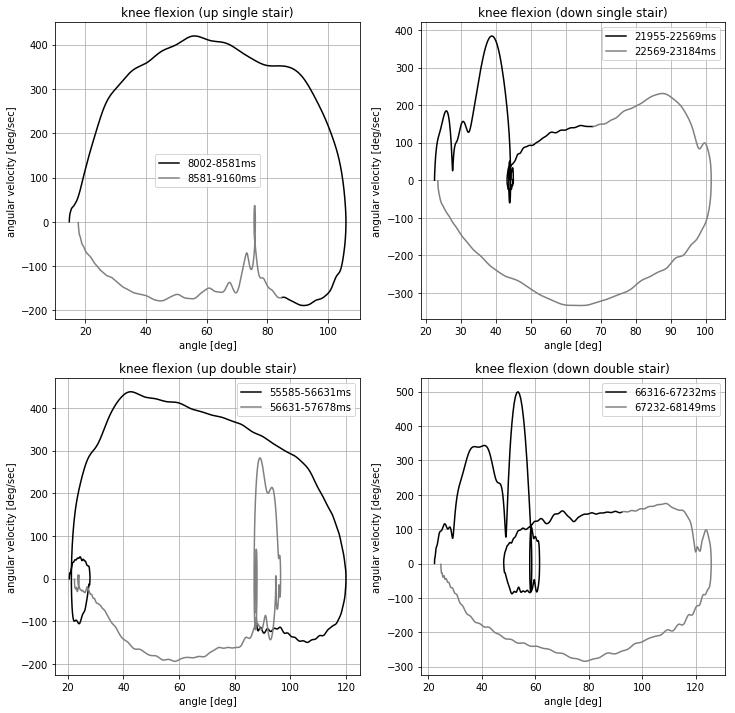

In [28]:
plt.figure(figsize=(12,12))

plt.subplot(2, 2, 1)
rv_plot(theta, omega, 8000, 9000, title='knee flexion (up single stair)')

plt.subplot(2, 2, 2)
rv_plot(theta, omega, 22000, 23000, title='knee flexion (down single stair)')

plt.subplot(2, 2, 3)
rv_plot(theta, omega, 56000, 58000, title='knee flexion (up double stair)')

plt.subplot(2, 2, 4)
rv_plot(theta, omega, 66000, 68000, title='knee flexion (down double stair)')

> **すばらしい！** 大きなループの中の小さなループは，１周期の膝屈曲伸展運動の途中に小さな膝屈曲伸展運動が生じている証拠だ。

◼️4-8. `rv-plot`関数は大腿の（傾き）角運動の位相空間解析にも適応できるので，ついでにそれらのグラフも表示してみよう：

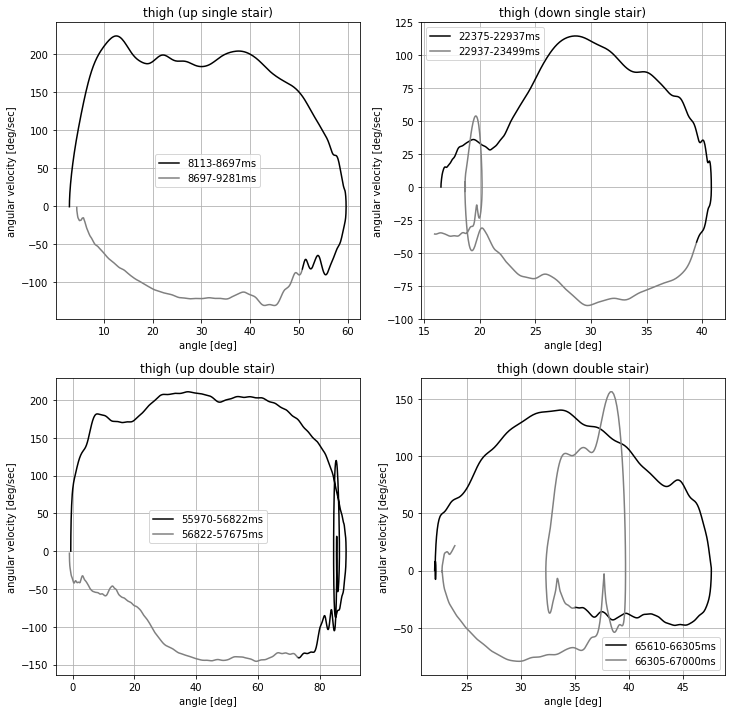

In [29]:
plt.figure(figsize=(12,12))

plt.subplot(2, 2, 1)
rv_plot(alpha, u1_z, 8000, 9000, title='thigh (up single stair)')

plt.subplot(2, 2, 2)
rv_plot(alpha, u1_z, 22000, 23000, title='thigh (down single stair)')

plt.subplot(2, 2, 3)
rv_plot(alpha, u1_z, 56000, 58000, title='thigh (up double stair)')

plt.subplot(2, 2, 4)
rv_plot(alpha, u1_z, 66000, 68000, title='thigh (down double stair)')

> 下腿は必要ない。なぜなら，大腿の傾き運動と膝屈曲角が決まれば，下腿の傾き運動は自動的に決まるからだ。

## ５．衝撃加速度と屈曲角運動

◼️5-1. 階段昇降実験の場合，昇降時に足底が階段に着地した瞬間に衝撃加速度が生じるはずである。それを確かめるために，データフレーム`df1`, `df2`から加速度部分を取り出して，numpy配列に直しておく：

In [30]:
a1_x = np.array(df['a1_x']/10000)[1500:]
a1_y = np.array(df['a1_y']/10000)[1500:]
a1_z = np.array(df['a1_z']/10000)[1500:]
a2_x = np.array(df['a2_x']/10000)[1500:]
a2_y = np.array(df['a2_y']/10000)[1500:]
a2_z = np.array(df['a2_z']/10000)[1500:]

> ローパスフィルタ処理は施さない。なぜなら，衝撃は非常に短い時間に起こるので，下手に周波数フィルタリングをかけると，それを取り損ねてしまうそれがあるからだ。また，各々の配列を1500インデックスから始めているのは，2-5で角速度について，最初の1500msを除去しているので，ここでもそうしておかなければならない。

◼️5-2. 大腿および下腿の**軸**に沿った加速度を4-3と同じ時間範囲でプロットしてみる：

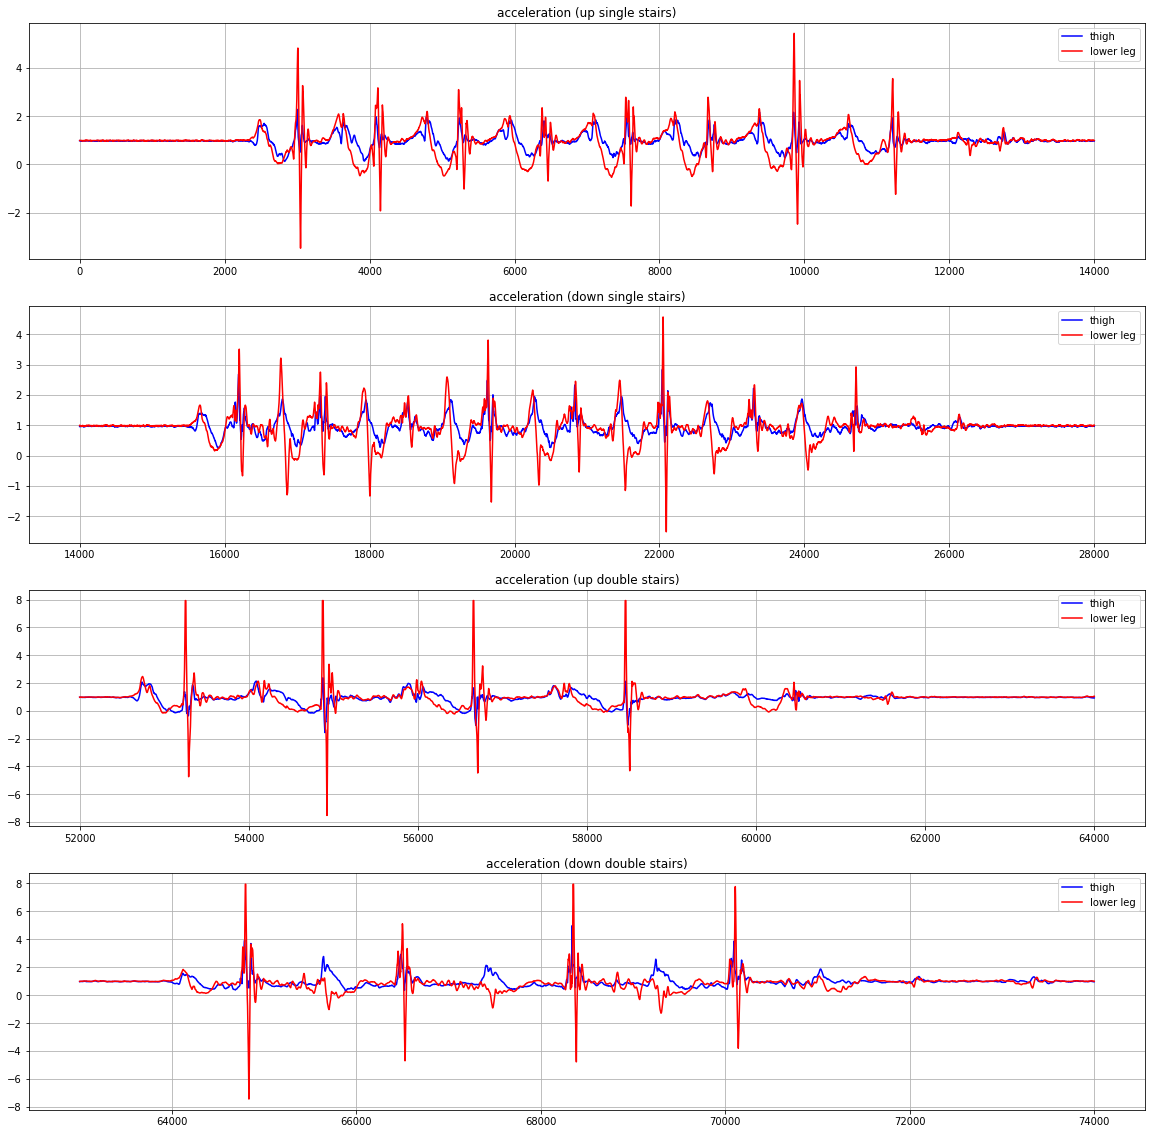

In [31]:
plt.figure(figsize=(20,20))

plt.subplot(4, 1, 1)
plt.plot(np.arange(14000), a1_x[:14000], c='blue')
plt.plot(np.arange(14000), a2_x[:14000], c='red')
plt.title('acceleration (up single stairs)')
plt.legend(['thigh', 'lower leg'])
plt.grid()

plt.subplot(4, 1, 2)
plt.plot(np.arange(14000, 28000), a1_x[14000:28000], c='blue')
plt.plot(np.arange(14000, 28000), a2_x[14000:28000], c='red')
plt.title('acceleration (down single stairs)')
plt.legend(['thigh', 'lower leg'])
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(np.arange(52000, 64000), a1_x[52000:64000], c='blue')
plt.plot(np.arange(52000, 64000), a2_x[52000:64000], c='red')
plt.title('acceleration (up double stairs)')
plt.legend(['thigh', 'lower leg'])
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(np.arange(63000, 74000), a1_x[63000:74000], c='blue')
plt.plot(np.arange(63000, 74000), a2_x[63000:74000], c='red')
plt.title('acceleration (down double stairs)')
plt.legend(['thigh', 'lower leg'])
plt.grid()

> 針のように尖った上むきの波形のが衝撃がかかっているところである。当然，大腿より下腿の方が大きな衝撃がかかる（←**なぜか？**）。ふむ。また予想に反して（？）昇りでも下りでも衝撃の(軸方向)の衝撃の最大値は変わらないように見える。特に**一段飛ばし**では，昇りの方が大きな衝撃がかかっているようにも見える（下腿においては，全て加速度センサの上限加速度8Gを超えている）。
>> 【問】衝撃がかかった後，加速度が必ず下にも針のように振れる。これは衝撃ではない。何か？考えよ。

◼️5-3. 衝撃が位相空間の膝屈曲角運動にどのように現れるのかを調べてみよう。衝撃は下腿加速度のx成分で確認する。
> 目で見てやらなければならないので，面倒臭いぞ！

▫︎5-3-1. 通常の昇

- 4-7の時間範囲の下腿加速度のx成分のグラフを描いてみる：

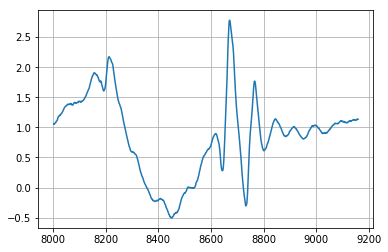

In [32]:
plt.plot(np.arange(8002, 9160), a2_x[8002:9160])
plt.grid()

- 上のグラフの時間範囲を`8600`〜`8800`msに絞る：

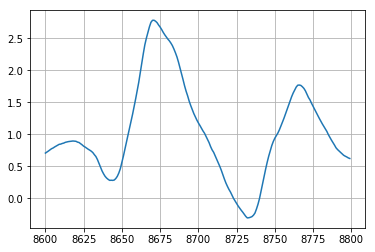

In [33]:
plt.plot(np.arange(8600, 8800), a2_x[8600:8800])
plt.grid()

- 4-7の第１位相空間グラフ`rv_plot(theta, omega, 8000, 9000, ...)`で，`redrange=[8625, 8725]`オプションを指定する。このオプションは，元の軌跡上に，右辺で指定したリストの時間範囲の軌跡を上書きする：

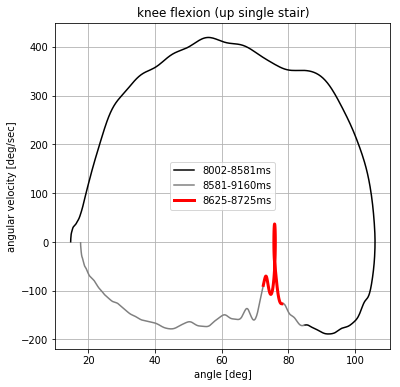

In [34]:
plt.figure(figsize=(6,6))
rv_plot(theta, omega, 8000, 9000, redrange=[8625, 8725], title='knee flexion (up single stair)')

> 上のグラフの軌跡の赤い部分が衝撃を受けた部分である。

▫︎5-3-2. 通常の降 
> やり方は5-3-1と同様である。

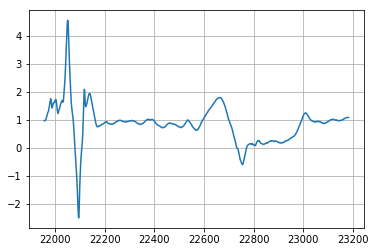

In [35]:
plt.plot(np.arange(21955, 23184), a2_x[21955:23184])
plt.grid()

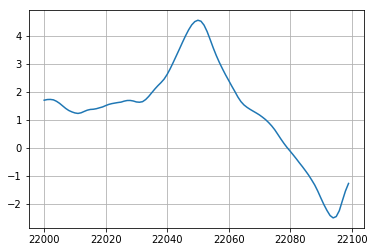

In [36]:
plt.plot(np.arange(22000, 22100), a2_x[22000:22100])
plt.grid()

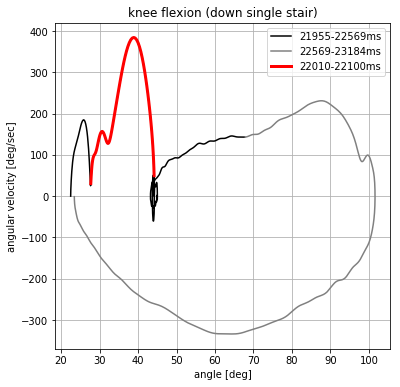

In [37]:
plt.figure(figsize=(6,6))
rv_plot(theta, omega, 22000, 23000, redrange=[22010, 22100], title='knee flexion (down single stair)')

> 上のグラフの軌跡の赤い部分が衝撃を受けた部分である。

▫︎5-3-3. １段飛ばしの昇  
> やり方は5-3-1と同様である。

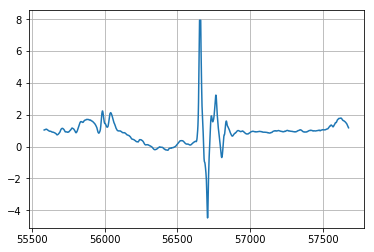

In [38]:
plt.plot(np.arange(55585, 57678), a2_x[55585:57678])
plt.grid()

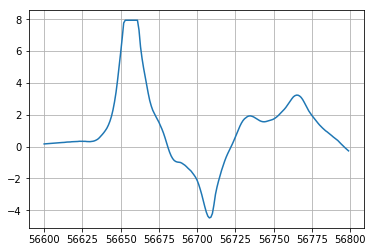

In [39]:
plt.plot(np.arange(56600, 56800), a2_x[56600:56800])
plt.grid()

> 富士山の形になっているのは，衝撃加速度がセンサの(設定)加速度上限の8Gを超えたため，これより大きな加速度を計測できなかった。

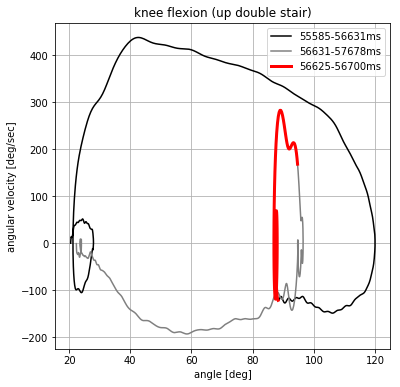

In [40]:
plt.figure(figsize=(6,6))
rv_plot(theta, omega, 55585, 57678, redrange=[56625, 56700], title='knee flexion (up double stair)')

> 上のグラフの軌跡の赤い部分が衝撃を受けた部分である。

▫︎5-3-4. １段飛ばしの降
> やり方は5-3-1と同様である。

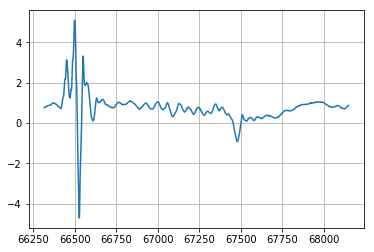

In [41]:
plt.plot(np.arange(66316, 68149), a2_x[66316:68149])
plt.grid()

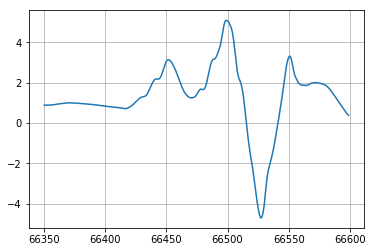

In [42]:
plt.plot(np.arange(66350, 66600), a2_x[66350:66600])
plt.grid()

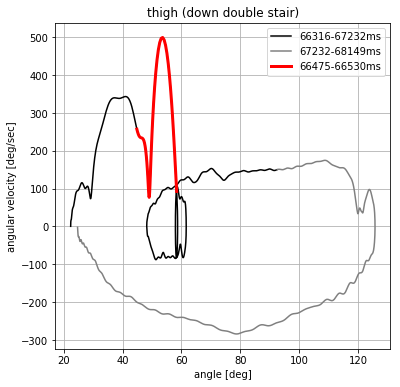

In [43]:
plt.figure(figsize=(6,6))
rv_plot(theta, omega, 66316, 68149, redrange=[66475, 66530], title='thigh (down double stair)')

> 上のグラフの軌跡の赤い部分が衝撃を受けた部分である。

◼️5-4. 5-3のグラフをまとめよう：

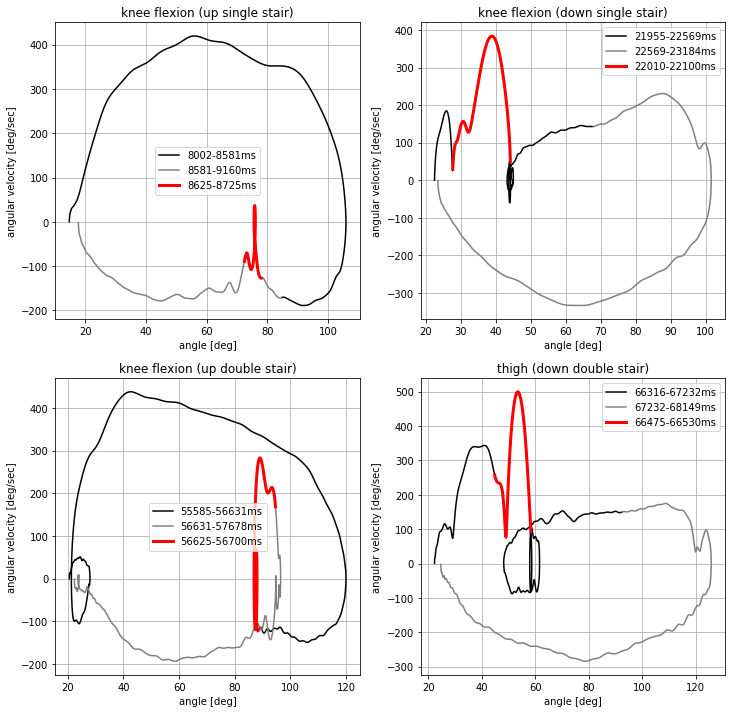

In [44]:
plt.figure(figsize=(12,12))

plt.subplot(2, 2, 1)
rv_plot(theta, omega, 8000, 9000, redrange=[8625, 8725], title='knee flexion (up single stair)')

plt.subplot(2, 2, 2)
rv_plot(theta, omega, 22000, 23000, redrange=[22010, 22100], title='knee flexion (down single stair)')

plt.subplot(2, 2, 3)
rv_plot(theta, omega, 55585, 57678, redrange=[56625, 56700], title='knee flexion (up double stair)')

plt.subplot(2, 2, 4)
rv_plot(theta, omega, 66316, 68149, redrange=[66475, 66530], title='thigh (down double stair)')

◼️5-5. 5-4と同じ時刻で大腿の角運動の位相空間軌跡を描いてみる：
> 4-8とは少し異なる。なぜなら，屈曲角の極小値と大腿傾き角の極小値が異なるからである：

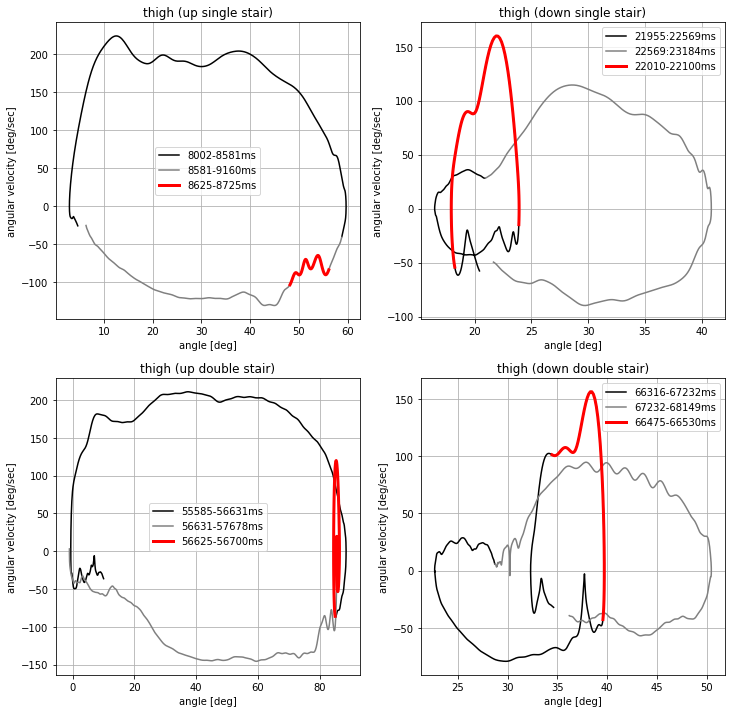

In [45]:
plt.figure(figsize=(12,12))

plt.subplot(2, 2, 1)
plt.plot(alpha[8002:8581], u1_z[8002:8581], c='black')
plt.plot(alpha[8581:9160], u1_z[8581:9160], c='gray')
plt.plot(alpha[8625:8725], u1_z[8625:8725], c='red', lw=3)
plt.legend(['8002-8581ms', '8581-9160ms', '8625-8725ms'])
plt.title('thigh (up single stair)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/sec]')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(alpha[21955:22569], u1_z[21955:22569], c='black')
plt.plot(alpha[22569:23184], u1_z[22569:23184], c='gray')
plt.plot(alpha[22010:22100], u1_z[22010:22100], c='red', lw=3)
plt.legend(['21955:22569ms', '22569:23184ms', '22010-22100ms'])
plt.title('thigh (down single stair)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/sec]')
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(alpha[55585:56631], u1_z[55585:56631], c='black')
plt.plot(alpha[56631:57678], u1_z[56631:57678], c='gray')
plt.plot(alpha[56625:56700], u1_z[56625:56700], c='red', lw=3)
plt.legend(['55585-56631ms', '56631-57678ms', '56625-56700ms'])
plt.title('thigh (up double stair)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/sec]')
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(alpha[66316:67232], u1_z[66316:67232], c='black')
plt.plot(alpha[67232:68149], u1_z[67232:68149], c='gray')
plt.plot(alpha[66475:66530], u1_z[66475:66530], c='red', lw=3)
plt.legend(['66316-67232ms', '67232-68149ms', '66475-66530ms'])
plt.title('thigh (down double stair)')
plt.xlabel('angle [deg]')
plt.ylabel('angular velocity [deg/sec]')
plt.grid()


> めんどくさい！　膝屈曲角運動と大腿傾き角運動（又は下腿傾き角運動）の両方の位相空間プロットしなければならないなら，プログラムで最初から両方を一度にプロットできるようにしとけよな〜。。って文句が言いたいよなあ。よろしい，そうしよう。

◼️5-6. 4-6の`rv-plot`を拡張し，膝屈曲角運動と大腿傾き角運動（又は下腿傾き角運動）の位相空間図を一度に描ける関数（プログラム）を作成しよう。関数名は`rv_plot2`とする：

In [46]:
def rv_plot2(r1, v1, r2, v2, t0, t1, epsilon=500, title1='', title2='', redrange=None):
    #0. r1とv2はそれぞれ対応する膝屈曲角とそれの角速度, t0とt1は第１と第２の極小値近傍時刻, itimeオプションは後のため
    ti = t0 - epsilon
    tf = t1 + epsilon
    tm = ti + (tf - ti) // 2    #tm は ti ~ tf の中間インデックス
    xi = np.where(r1==np.min(r1[ti:tm]))[0][0]    #xi は ti ~ tm までの r の最小値のインデックス
    xf = np.where(r1==np.min(r1[tm:tf]))[0][0]    #xf は tm ~ tf までの r の最小値のインデックス
    xm = xi + (xf - xi) // 2    #xm は xi ~ xf の中間インデックス
    
    #1. 膝屈曲角プロット
    plt.subplot(1, 2, 1)
    plt.plot(r1[xi:xm], v1[xi:xm], c='black')
    plt.plot(r1[xm:xf], v1[xm:xf], c='gray')
    if redrange != None:
        plt.plot(r1[redrange[0]:redrange[1]], v1[redrange[0]:redrange[1]], c='red', lw=3) #指定個所に赤い曲線を上描き
        plt.legend([f'{xi}-{xm}ms', f'{xm}-{xf}ms',  f'{redrange[0]}-{redrange[1]}ms'])
    else:
        plt.legend([f'{xi}-{xm}ms', f'{xm}-{xf}ms'])    #すぐ上のコードがあるのでエラーを出さないためにelse内部に書いた
    plt.title(f'{title1}')
    plt.xlabel('angle [deg]')
    plt.ylabel('angular velocity [deg/sec]')                                
    plt.grid()
    
    #2. 大腿(下腿)傾き角プロット
    plt.subplot(1, 2, 2)
    plt.plot(r2[xi:xm], v2[xi:xm], c='black')
    plt.plot(r2[xm:xf], v2[xm:xf], c='gray')
    if redrange != None:
        plt.plot(r2[redrange[0]:redrange[1]], v2[redrange[0]:redrange[1]], c='red', lw=3) #指定個所に赤い曲線を上描き
        plt.legend([f'{xi}-{xm}ms', f'{xm}-{xf}ms',  f'{redrange[0]}-{redrange[1]}ms'])
    else:
        plt.legend([f'{xi}-{xm}ms', f'{xm}-{xf}ms'])    #すぐ上のコードがあるのでエラーを出さないためにelse内部に書いた       
    plt.title(f'{title2}')
    plt.xlabel('angle [deg]')
    plt.ylabel('angular velocity [deg/sec]')                                
    plt.grid()

> 自分で言うのもなんだが，汚いプログラム。。このプログラム，内部に`plt.subplot`関数を使ってしまっているので（右図に膝屈曲角図，左図に大腿傾き角図又は下腿傾き角図），**使用するときに`plt.subplot`関数はつかえません。**つまり，１度に２つずつしか図は描きません。もっとうまくプログラムできた人は加点。

◼️5-7. 5-6の関数`rv_plot2`を利用して，膝屈曲角運動と下腿傾き角運動を位相空間に描いてみよう。ただし，膝屈曲角の１周期の時刻は4-7の範囲にとり，衝撃時刻は5-3で範囲にとる：  

| 昇降 | １段飛ばし | 時刻範囲[ms] | 衝撃時刻[ms] |  
|---|---|---|---|  
| 昇 | なし | 8000 - 9000 | 8625 - 8725 |
| 降 | なし | 22000 - 23000 | 22010 - 22100 |
| 昇 | あり | 56000 - 58000 | 56625 - 56700 |
| 降 | あり | 66000 - 68000 | 66475 - 66530 |


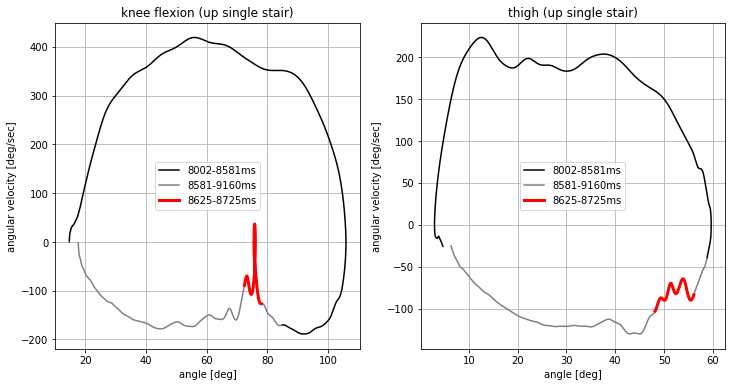

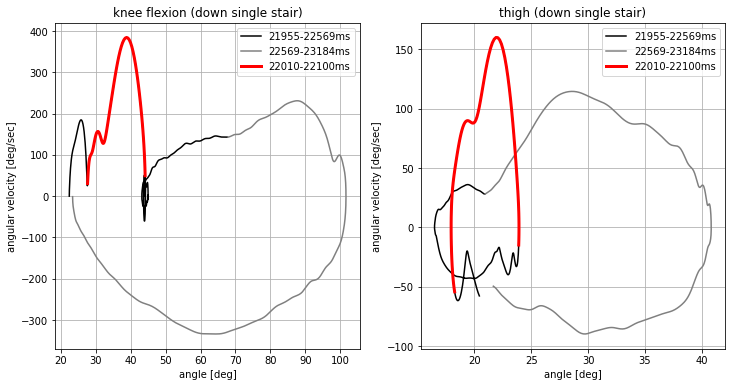

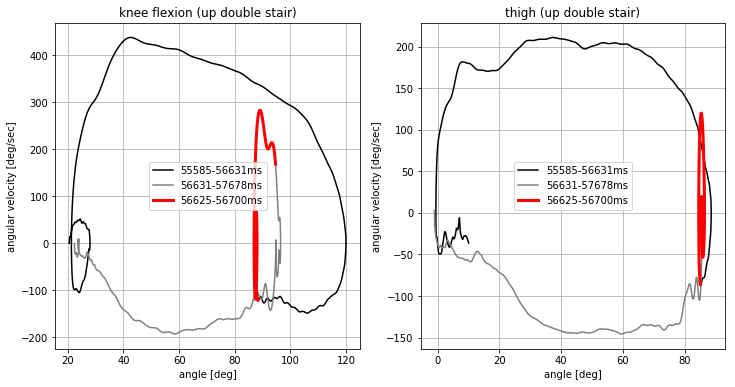

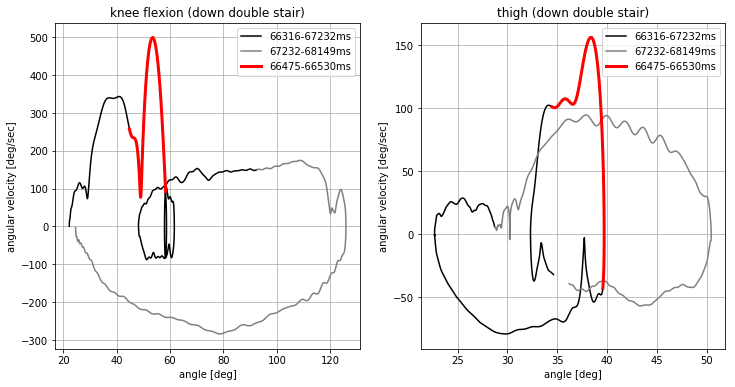

In [47]:
plt.figure(figsize=(12,6))
rv_plot2(theta, omega, alpha, u1_z, 8000, 9000, 
         title1='knee flexion (up single stair)', title2='thigh (up single stair)', 
         redrange=[8625, 8725])

plt.figure(figsize=(12,6))
rv_plot2(theta, omega, alpha, u1_z, 22000, 23000, 
         title1='knee flexion (down single stair)', title2='thigh (down single stair)', 
         redrange=[22010, 22100])

plt.figure(figsize=(12,6))
rv_plot2(theta, omega, alpha, u1_z, 56000, 58000,
        title1='knee flexion (up double stair)', title2='thigh (up double stair)', 
        redrange=[56625, 56700])

plt.figure(figsize=(12,6))
rv_plot2(theta, omega, alpha, u1_z, 66000, 68000,
        title1='knee flexion (down double stair)', title2='thigh (down double stair)', 
        redrange=[66475, 66530])